In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

# Import package
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from src.exchange import TOB_Exchange
from src.latency_models import LogNormalLatency

%load_ext autoreload 
%autoreload 2

## Load data

In [2]:
base = 'BTC'
quote = 'USDT'

folder_path = 'data_loader/datasets/'
files_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'binance' 
    and f.split('_')[-1] == base+quote+'.csv.gz'
    and f.split('_')[1] == 'quotes']

tfiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'binance' 
    and f.split('_')[-1] == base+quote+'.csv.gz'
    and f.split('_')[1] == 'trades']

ufiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'upbit' 
    and f.split('_')[-1] == f'{quote}-{base}.csv.gz'
    and f.split('_')[1] == 'quotes']

utfiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'upbit' 
    and f.split('_')[-1] == f'{quote}-{base}.csv.gz'
    and f.split('_')[1] == 'trades']

In [3]:
def get_data(files_list):
    df = pd.DataFrame()
    # Use a loop to get all the csv.gz files from the path location in a single Dataframe
    for csv_file in tqdm(files_list):
        file_name = (folder_path + csv_file)
        if file_name[-2:] == "gz":
            df1 = pd.read_csv(file_name, compression='gzip')
            # Concatenate all the dataframes into a single dataframe
            df = pd.concat([df, df1], ignore_index=True)

    df['time'] = pd.to_datetime(df.timestamp, unit='us')
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)
    return df

In [4]:
upbit_data = get_data(ufiles_list)
binance_data = get_data(files_list)

upbit_trades_data = get_data(utfiles_list)
binance_trades_data = get_data(tfiles_list)

100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


In [5]:
binance_lst = binance_data[['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy()
binance_trades_lst = binance_trades_data[['timestamp', 'id', 'side', 'price', 'amount']].to_numpy()
upbit_lst = upbit_data[['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy()
upbit_trades_lst =  upbit_trades_data[['timestamp', 'id', 'side', 'price', 'amount']].to_numpy()

In [79]:
symbol = base + quote

hedging = TOB_Exchange(latency=LogNormalLatency(5000, 0.3))
hedging.add_market(symbol, base, quote)
hedging.add_balance(base, 0.3)
hedging.add_balance(quote, 0)
hedging.load_tob(binance_lst, symbol)
hedging.load_trades(binance_trades_lst, symbol)

2023-08-01 20:41:26,604 - INFO - src.exchange - Loading 487428 TOB-Updates for BTCUSDT
2023-08-01 20:41:26,604 - INFO - src.exchange - Loading 487428 TOB-Updates for BTCUSDT
2023-08-01 20:41:26,604 - INFO - src.exchange - Loading 487428 TOB-Updates for BTCUSDT
2023-08-01 20:41:28,591 - INFO - src.exchange - TOB-Updates loaded successfully
2023-08-01 20:41:28,591 - INFO - src.exchange - TOB-Updates loaded successfully
2023-08-01 20:41:28,591 - INFO - src.exchange - TOB-Updates loaded successfully
2023-08-01 20:41:28,592 - INFO - src.exchange - Loading 567976 trades for BTCUSDT
2023-08-01 20:41:28,592 - INFO - src.exchange - Loading 567976 trades for BTCUSDT
2023-08-01 20:41:28,592 - INFO - src.exchange - Loading 567976 trades for BTCUSDT
2023-08-01 20:41:30,561 - INFO - src.exchange - Trades loaded successfully
2023-08-01 20:41:30,561 - INFO - src.exchange - Trades loaded successfully
2023-08-01 20:41:30,561 - INFO - src.exchange - Trades loaded successfully


In [80]:
origin = TOB_Exchange(latency=LogNormalLatency(5000, 0.3))
origin.add_market(symbol, base, quote)
origin.add_balance(base, 0)
origin.add_balance(quote, 10_000)
origin.load_tob(upbit_lst, symbol)
origin.load_trades(upbit_trades_lst, symbol)

2023-08-01 20:41:30,574 - INFO - src.exchange - Loading 14261 TOB-Updates for BTCUSDT
2023-08-01 20:41:30,574 - INFO - src.exchange - Loading 14261 TOB-Updates for BTCUSDT
2023-08-01 20:41:30,574 - INFO - src.exchange - Loading 14261 TOB-Updates for BTCUSDT
2023-08-01 20:41:30,603 - INFO - src.exchange - TOB-Updates loaded successfully
2023-08-01 20:41:30,603 - INFO - src.exchange - TOB-Updates loaded successfully
2023-08-01 20:41:30,603 - INFO - src.exchange - TOB-Updates loaded successfully
2023-08-01 20:41:30,604 - INFO - src.exchange - Loading 246 trades for BTCUSDT
2023-08-01 20:41:30,604 - INFO - src.exchange - Loading 246 trades for BTCUSDT
2023-08-01 20:41:30,604 - INFO - src.exchange - Loading 246 trades for BTCUSDT
2023-08-01 20:41:30,605 - INFO - src.exchange - Trades loaded successfully
2023-08-01 20:41:30,605 - INFO - src.exchange - Trades loaded successfully
2023-08-01 20:41:30,605 - INFO - src.exchange - Trades loaded successfully


In [81]:
class cross_exchange: 
    def __init__(self):
        self.base = 'BTC'
        self.quote = 'USDT'
        self.symbol = self.base + self.quote
        self.amount = 0.01

        self.distance = 100 / 10_000 # place orders at 10bps distance
        self.sensitivity =  60 / 10_000 # after a move of 4bps, replace the order

        self.last_trade = None

        self.timestamp = None

        self.current_bid = None 
        self.current_ask = None

        self.hedging_ask = None 
        self.hedging_bid = None

        self.bid_open = None 
        self.ask_open = None

        self.initial_sell = False
        self.initial_buy = False

        self.counter = 0
        self.balances = []

    def run_strategy(self):

        hedging_tob = hedging.fetch_tob(self.symbol)
        origin_tob = origin.fetch_tob(self.symbol)
        self.current_ask = origin_tob['ask_price']
        self.current_bid = origin_tob['bid_price']
        self.hedging_ask = hedging_tob['ask_price']
        self.hedging_bid = hedging_tob['bid_price']

        self.timestamp = max(origin_tob['timestamp'], hedging_tob['timestamp'])

        # If a trade was executed on the origin, make a market order on the hedging exchange
        if len(origin.trades) > 0: 
            if origin.trades[-1] != self.last_trade:
                self.last_trade = origin.trades[-1]

                if self.last_trade.side: 
                    side = 0 
                    self.initial_buy = False

                else: 
                    side = 1
                    self.initial_sell = False

                print('hedging')
                hedging.market_order(self.symbol, self.amount, side, self.timestamp)

        # Open orders if they currently arent open
        if len(origin.open_orders[self.symbol][0]) == 0 and not self.initial_sell: 
            new_price = round(self.hedging_ask * (1 + self.distance), 8)
            print(f'Sell {self.amount} @ {new_price} with {self.hedging_ask}')
            origin.limit_order(
                self.symbol, self.amount, new_price, 0, self.timestamp
            )
            self.ask_open = self.hedging_ask
            self.initial_sell = True

        # if the price moved too much, replace the order
        elif (abs(self.ask_open / self.hedging_ask - 1) > self.sensitivity) and (len(origin.open_orders[self.symbol][0]) > 0): 
            new_price = round(self.hedging_ask * (1 + self.distance), 8)
            print(f'Replacing sell {self.amount} @ {new_price} with {self.hedging_ask}')
            origin.cancel_order(origin.open_orders[self.symbol][0].peekitem(0)[1])
            origin.limit_order(
                self.symbol, self.amount, new_price, 0, self.timestamp
            )
            self.ask_open = self.hedging_ask

        if len(origin.open_orders[self.symbol][1]) == 0 and not self.initial_buy: 
            new_price = round(self.hedging_ask * (1 - self.distance), 8)
            print(f'Buy {self.amount} @ {new_price} with {self.hedging_bid}')
            origin.limit_order(
                self.symbol, self.amount, new_price, 1, self.timestamp
            )
            self.bid_open = self.hedging_bid
            self.initial_buy = True

        # if the price moved too much, replace the order
        elif (abs(self.bid_open / self.hedging_ask - 1) > self.sensitivity) and (len(origin.open_orders[self.symbol][1]) > 0): 
            new_price = round(self.hedging_ask * (1 - self.distance), 8)
            print(f'Replacing buy {self.amount} @ {new_price} with {self.hedging_bid}')
            origin.cancel_order(origin.open_orders[self.symbol][1].peekitem(0)[1])
            origin.limit_order(
                self.symbol, self.amount, new_price, 0, self.timestamp
            )
            self.bid_open = self.hedging_bid


        # Run the simulation step in the place where we are behind
        if hedging_tob['timestamp'] > origin_tob['timestamp']: 
            origin._simulation_step()
        else: 
            hedging._simulation_step()

    def run_simulation(self):
        while (len(origin.events) > 0) and (len(hedging.events) > 0): 
            self.run_strategy()

            self.counter += 1
            if self.counter % 100:
                update = origin.balances.copy()
                u_2 = hedging.balances.copy()

                update['base_hedging'] = u_2[self.base]
                update['quote_hedging'] = u_2[self.quote]
                update["mid"] = (
                    self.hedging_ask + self.hedging_bid
                ) / 2
                update["ts"] = self.timestamp

                self.balances.append(update)

In [82]:
strategy = cross_exchange()
strategy.run_simulation()

2023-08-01 20:41:30,744 - WARNING - src.exchange - Sell Order couldnt be opened, not enough balance available 
Opened Amount: 0.01, Available Amount: 0
2023-08-01 20:41:30,744 - WARNING - src.exchange - Sell Order couldnt be opened, not enough balance available 
Opened Amount: 0.01, Available Amount: 0
2023-08-01 20:41:30,744 - WARNING - src.exchange - Sell Order couldnt be opened, not enough balance available 
Opened Amount: 0.01, Available Amount: 0


Sell 0.01 @ 30776.72 with 30472.0
Buy 0.01 @ 30167.28 with 30471.99


2023-08-01 20:41:31,042 - INFO - src.exchange - Trade match found! Order Order(order_id=155, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainingAmount=0.01, price=30167.28, entryTime=1688169601357137.5, eventTime=1688169601359862.5, status='open', parentLevel=None) will be opened
2023-08-01 20:41:31,042 - INFO - src.exchange - Trade match found! Order Order(order_id=155, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainingAmount=0.01, price=30167.28, entryTime=1688169601357137.5, eventTime=1688169601359862.5, status='open', parentLevel=None) will be opened
2023-08-01 20:41:31,042 - INFO - src.exchange - Trade match found! Order Order(order_id=155, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainingAmount=0.01, price=30167.28, entryTime=1688169601357137.5, eventTime=1688169601359862.5, status='open', parentLevel=None) will be opened
2023-08-01 20:41:31,043 - INFO - src.exchange - Trade Executed Trade(symbol='BTCUSDT', trade_id=3977677, order_id=155, side=1, 

hedging
Buy 0.01 @ 30173.616 with 30478.39
hedging
Buy 0.01 @ 30173.616 with 30478.39
hedging
Buy 0.01 @ 30173.616 with 30478.39
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 30486.57
hedging
Buy 0.01 @ 30181.7142 with 

In [83]:
bal = pd.DataFrame(strategy.balances)
bal.index = pd.to_datetime(bal.ts, unit='us')

bal['base_usd'] = bal[base] * bal.mid
bal['base_usd_hedging'] = bal.base_hedging * bal.mid
bal['combined_origin'] = bal.base_usd + bal[quote]
bal['combined_hedging'] = bal.quote_hedging + bal.base_usd_hedging

bal['bh_base'] = 0.3
bal['bh_quote'] = 10_000

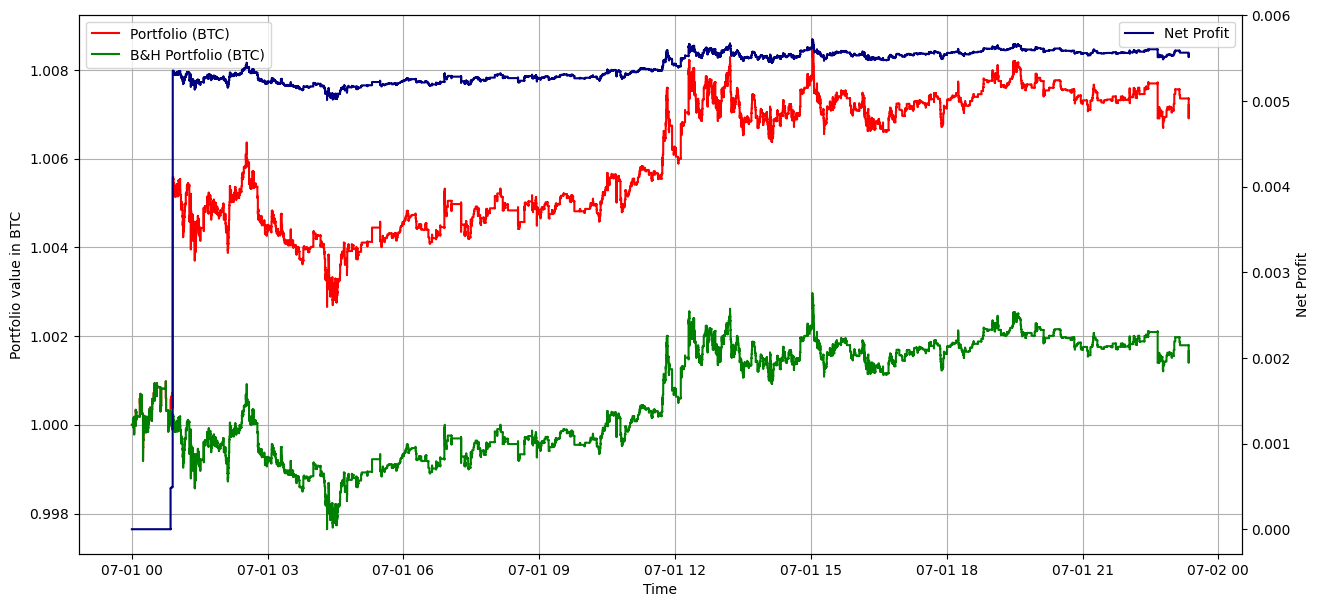

In [84]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.plot((1+(bal.combined_origin + bal.combined_hedging).pct_change()).cumprod(), label='Portfolio (BTC)', color='r')
ax.plot((1+(bal.bh_quote + bal.bh_base * bal.mid).pct_change()).cumprod(), label='B&H Portfolio (BTC)', color='g')

ax2 = ax.twinx()
ax2.plot((1+(bal.combined_origin + bal.combined_hedging).pct_change()).cumprod() - (1+(bal.bh_quote + bal.bh_base * bal.mid).pct_change()).cumprod(), label='Net Profit', color='navy')
#ax2.plot(bal.mid, label='COMPBTC Price')
ax.set_xlabel('Time')
ax2.set_ylabel('Net Profit')
ax.set_ylabel('Portfolio value in BTC')
ax.legend(loc=2)
ax2.legend(loc=1)
ax.grid()

## Trade Exploration

In [47]:
binance_data.set_index('timestamp', inplace=True)
upbit_data.set_index('timestamp', inplace=True)

KeyError: "None of ['timestamp'] are in the columns"

In [85]:
start =int(datetime(2023, 7, 1, 0, 0).timestamp() * 1_000_000)
end = int(datetime(2023, 7, 1, 3, 0).timestamp() * 1_000_000)

In [91]:
o_trades = pd.DataFrame(origin.trades)
h_trades = pd.DataFrame(hedging.trades)
orders = pd.DataFrame(origin.orders)

In [92]:
h_trades

,symbol,trade_id,order_id,side,taker,amount,price,fees,entryTime,eventTime
0,BTCUSDT,3977680,158,0,True,0.01,30478.39,0.060957,1.688173e+15,1.688173e+15
1,BTCUSDT,3977681,160,0,True,0.01,30478.39,0.060957,1.688173e+15,1.688173e+15
2,BTCUSDT,3977682,156,0,True,0.01,30478.39,0.060957,1.688173e+15,1.688173e+15
3,BTCUSDT,3977684,162,0,True,0.01,30486.57,0.060973,1.688173e+15,1.688173e+15
4,BTCUSDT,3977714,186,0,True,0.01,30486.57,0.060973,1.688173e+15,1.688173e+15
5,BTCUSDT,3977715,172,0,True,0.01,30486.57,0.060973,1.688173e+15,1.688173e+15
6,BTCUSDT,3977716,194,0,True,0.01,30486.57,0.060973,1.688173e+15,1.688173e+15
7,BTCUSDT,3977717,202,0,True,0.01,30486.57,0.060973,1.688173e+15,1.688173e+15
8,BTCUSDT,3977718,218,0,True,0.01,30486.57,0.060973,1.688173e+15,1.688173e+15
9,BTCUSDT,3977719,216,0,True,0.01,30486.57,0.060973,1.688173e+15,1.688173e+15


In [87]:
for i in [o_trades, h_trades, orders]:
    if len(i) > 0:
        i['entryTime'] = pd.to_datetime(i['entryTime'], unit='us')
        i['eventTime'] = pd.to_datetime(i['eventTime'], unit='us')

In [ ]:
binance_data.index = pd.to_datetime(binance_data.index, unit='us')
upbit_data.index = pd.to_datetime(upbit_data.index, unit='us')

AttributeError: 'DataFrame' object has no attribute 'entryTime'

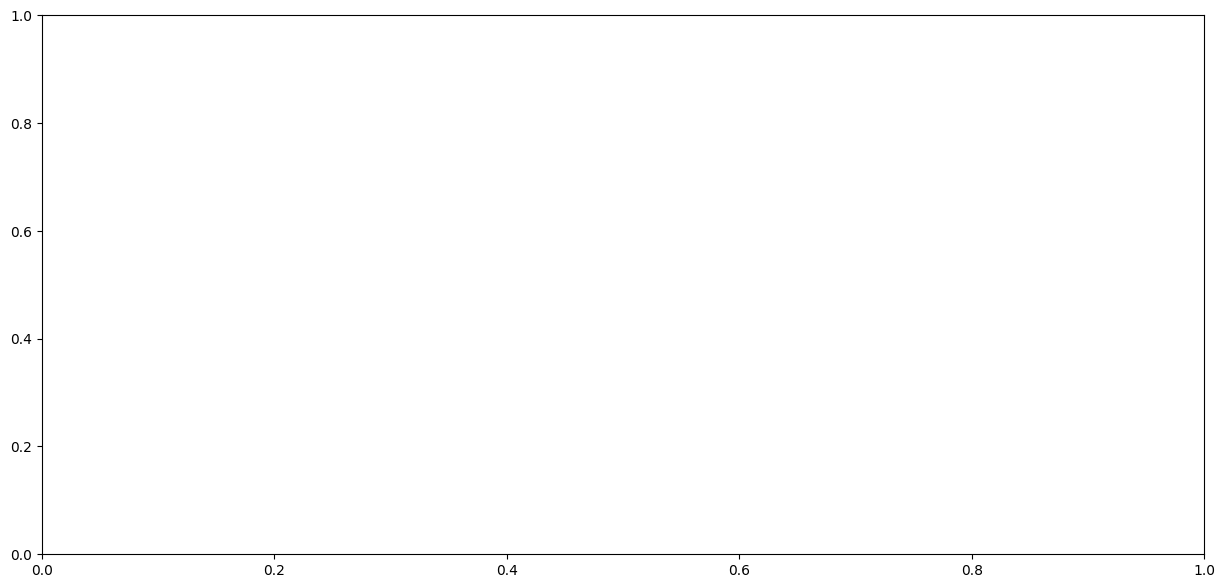

In [27]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.scatter(o_trades.entryTime[0], o_trades.price[0], color='yellow', label='origin trade')
ax.scatter(o_trades.eventTime[0], o_trades.price[0], color='yellow', label='origin trade')
ax.scatter(h_trades.entryTime[0], h_trades.price[0], color='orange', label='hedge trade')
ax.scatter(h_trades.eventTime[0], h_trades.price[0], color='orange', label='hedge trade')

ax.set_xlabel('Time')
ax.set_ylabel('Price in Quote Currency')
ax.legend(loc=1)
ax.grid()

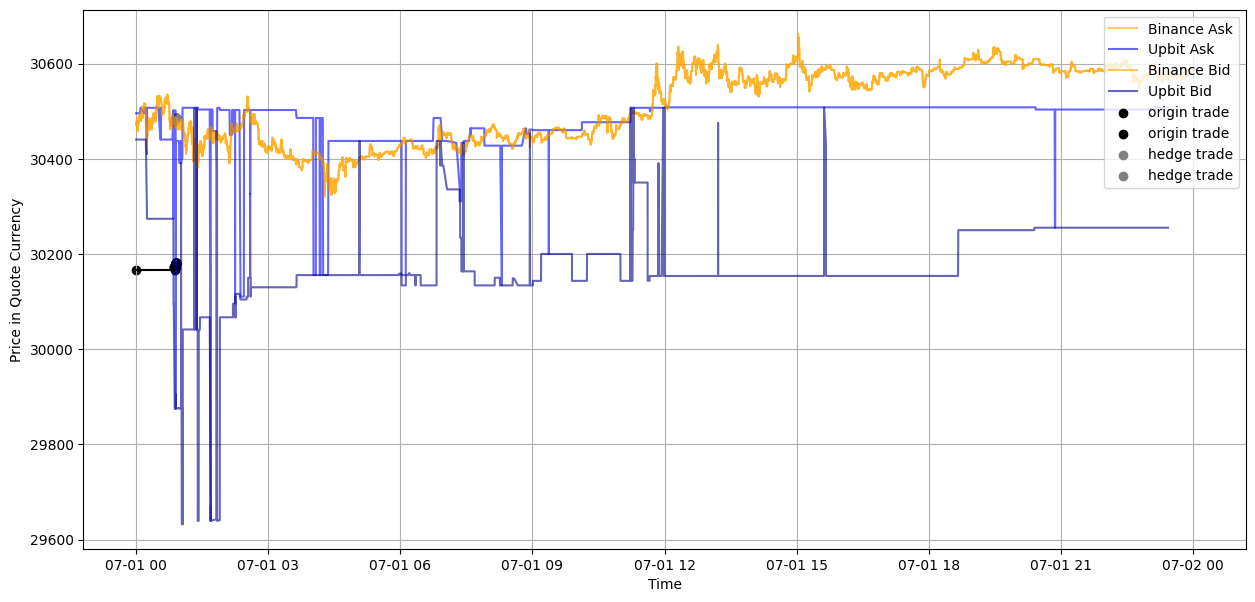

In [88]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.plot(binance_data['ask_price'], label='Binance Ask', color='orange', alpha=0.6)
ax.plot(upbit_data['ask_price'], label='Upbit Ask', color='blue', alpha=0.6)
ax.plot(binance_data['bid_price'], label='Binance Bid', color='orange', alpha=0.6)
ax.plot(upbit_data['bid_price'], label='Upbit Bid', color='darkblue', alpha=0.6)

ax.scatter(o_trades.entryTime, o_trades.price, color='black', label='origin trade')
ax.scatter(o_trades.eventTime, o_trades.price, color='black', label='origin trade')
ax.scatter(h_trades.entryTime, h_trades.price, color='grey', label='hedge trade')
ax.scatter(h_trades.eventTime, h_trades.price, color='grey', label='hedge trade')

ax.hlines(y=orders.price, xmin=orders.entryTime, xmax=orders.eventTime, colors='black', alpha=1, linestyles='solid')

ax.set_xlabel('Time')
ax.set_ylabel('Price in Quote Currency')
ax.legend(loc=1)
ax.grid()